In [1]:
# ===== 모델 초기화 (Apple Silicon Metal GPU) =====
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import tensorflow as tf

print(f"TensorFlow 버전: {tf.__version__}")

# Metal GPU 확인 및 활성화
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f"✅ Metal GPU 발견: {len(gpus)}개")
    for gpu in gpus:
        print(f"   - {gpu.name}")
    # Metal에서는 memory_growth 설정하지 않음 (오히려 문제 발생)
    print("✅ Apple Silicon Metal GPU 활성화됨!")
else:
    print("⚠️ GPU가 발견되지 않았습니다. CPU를 사용합니다.")

# 간단한 GPU 테스트
print("\n=== GPU 연산 테스트 ===")
with tf.device('/GPU:0'):
    a = tf.random.normal([1000, 1000])
    b = tf.random.normal([1000, 1000])
    c = tf.matmul(a, b)
print(f"GPU 연산 테스트 완료: shape = {c.shape}")

# Keras 백엔드 초기화
tf.keras.backend.clear_session()
print("\n✅ TensorFlow 및 Metal GPU 초기화 완료")

TensorFlow 버전: 2.16.2
✅ Metal GPU 발견: 1개
   - /physical_device:GPU:0
✅ Apple Silicon Metal GPU 활성화됨!

=== GPU 연산 테스트 ===
GPU 연산 테스트 완료: shape = (1000, 1000)

✅ TensorFlow 및 Metal GPU 초기화 완료


# 피싱 탐지를 위한 임베딩 모델

이 노트북은 피싱 탐지를 위한 임베딩 모델을 학습합니다.

## 목표
- Autoencoder를 사용하여 피싱 데이터의 저차원 임베딩 생성
- 학습된 임베딩 공간에서 코사인 유사도를 사용한 피싱 탐지
- 정상/피싱 샘플의 프로토타입 벡터 생성 및 저장

## 프레임워크
1. 데이터 로드 및 전처리
2. Autoencoder 모델 학습 (차원 축소)
3. 임베딩 공간에서 정상/피싱 프로토타입 생성
4. 유사도 기반 분류기 테스트
5. 모델 및 프로토타입 저장

In [2]:
# ===== 0) 환경 설정 및 Import =====
import os
os.environ['CONDA_DEFAULT_ENV'] = 'tf_env'

import gc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, accuracy_score, classification_report
from sklearn.metrics.pairwise import cosine_similarity
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Model

print("TensorFlow 버전:", tf.__version__)
print("NumPy 버전:", np.__version__)
print("Pandas 버전:", pd.__version__)

TensorFlow 버전: 2.16.2
NumPy 버전: 1.26.4
Pandas 버전: 2.3.3


In [6]:
# ===== 1) 설정 =====
DATA_PATH = "/Users/seungmin/AndroidStudioProjects/YU_mobile_kotlin/phishing/uci-ml-phishing-dataset.csv"
TARGET_COL = "Result"
EMBEDDING_DIM = 32  # 임베딩 차원 (원래 설정으로 복원)
BATCH_SIZE = 64  # 배치 크기 (원래 설정으로 복원)
EPOCHS = 200  # 에폭 (원래 설정으로 복원)
LEARNING_RATE = 0.001
RANDOM_SEED = 42

# 시드 설정
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

print(f"설정 완료: 임베딩 차원={EMBEDDING_DIM}, 배치 크기={BATCH_SIZE}, 에폭={EPOCHS}")

설정 완료: 임베딩 차원=32, 배치 크기=64, 에폭=200


In [7]:
# ===== 2) 데이터 로드 및 전처리 =====
df = pd.read_csv(DATA_PATH)
print(f"데이터 shape: {df.shape}")
print(f"\n컬럼 목록:\n{df.columns.tolist()}")
print(f"\n처음 5행:\n{df.head()}")

# 타겟 변수 확인
print(f"\n타겟 변수 ({TARGET_COL}) 분포:")
print(df[TARGET_COL].value_counts())

데이터 shape: (11055, 23)

컬럼 목록:
['id', 'having_IP_Address', 'URL_Length', 'Shortining_Service', 'having_At_Symbol', 'double_slash_redirecting', 'Prefix_Suffix', 'having_Sub_Domain', 'SSLfinal_State', 'Favicon', 'port', 'HTTPS_token', 'Request_URL', 'URL_of_Anchor', 'Links_in_tags', 'SFH', 'Submitting_to_email', 'Redirect', 'on_mouseover', 'RightClick', 'popUpWidnow', 'Iframe', 'Result']

처음 5행:
   id  having_IP_Address  URL_Length  Shortining_Service  having_At_Symbol  \
0   1                 -1           1                   1                 1   
1   2                  1           1                   1                 1   
2   3                  1           0                   1                 1   
3   4                  1           0                   1                 1   
4   5                  1           0                  -1                 1   

   double_slash_redirecting  Prefix_Suffix  having_Sub_Domain  SSLfinal_State  \
0                        -1             -1           

In [8]:
# ===== 3) 피처 및 레이블 분리 =====
# 'id' 컬럼이 있다면 제거
if 'id' in df.columns:
    df = df.drop(columns=['id'])

# 타겟 변수를 이진 레이블로 변환 (-1: 피싱, 1: 정상 -> 0: 피싱, 1: 정상)
y = df[TARGET_COL].values
y_binary = (y == 1).astype(np.float32)  # 1: 정상(legitimate), 0: 피싱(phishing)

# 피처 추출 (타겟 제외)
X = df.drop(columns=[TARGET_COL]).values.astype(np.float32)

print(f"피처 shape: {X.shape}")
print(f"레이블 shape: {y_binary.shape}")
print(f"레이블 분포: 정상={np.sum(y_binary==1)}, 피싱={np.sum(y_binary==0)}")

# Train/Val/Test 분리 (60/20/20)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y_binary, test_size=0.4, stratify=y_binary, random_state=RANDOM_SEED
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=RANDOM_SEED
)

print(f"\nTrain: {X_train.shape}, Val: {X_val.shape}, Test: {X_test.shape}")

피처 shape: (11055, 21)
레이블 shape: (11055,)
레이블 분포: 정상=6157, 피싱=4898

Train: (6633, 21), Val: (2211, 21), Test: (2211, 21)


In [9]:
# ===== 4) 데이터 확인 (스케일링 없이 원본 사용) =====
# UCI 피싱 데이터셋은 이미 -1, 0, 1로 정규화되어 있음
# 원본 스케일을 유지하여 범주형 의미 보존

# 원본 데이터를 그대로 사용 (스케일링 제거)
X_train_scaled = X_train.copy()
X_val_scaled = X_val.copy()
X_test_scaled = X_test.copy()

print("데이터 전처리 완료 (원본 스케일 유지)")
print(f"Train 피처 범위: min={X_train_scaled.min():.2f}, max={X_train_scaled.max():.2f}")
print(f"Train 피처 고유값: {np.unique(X_train_scaled)[:10]}")
print("\n⚠️ 참고: StandardScaler 제거됨 - 원본 -1, 0, 1 값 사용")

데이터 전처리 완료 (원본 스케일 유지)
Train 피처 범위: min=-1.00, max=1.00
Train 피처 고유값: [-1.  0.  1.]

⚠️ 참고: StandardScaler 제거됨 - 원본 -1, 0, 1 값 사용


In [10]:
# ===== 5) Autoencoder 모델 구축 =====
keras.backend.clear_session()
gc.collect()

input_dim = X_train_scaled.shape[1]

# Encoder
encoder_input = keras.Input(shape=(input_dim,), name='encoder_input')
x = layers.Dense(128, activation='relu', name='encoder_dense1')(encoder_input)
x = layers.BatchNormalization(name='encoder_bn1')(x)
x = layers.Dropout(0.3, name='encoder_dropout1')(x)
x = layers.Dense(64, activation='relu', name='encoder_dense2')(x)
x = layers.BatchNormalization(name='encoder_bn2')(x)
x = layers.Dropout(0.2, name='encoder_dropout2')(x)
x = layers.Dense(32, activation='relu', name='encoder_dense3')(x)
embedding = layers.Dense(EMBEDDING_DIM, activation='linear', name='embedding')(x)

# Decoder
x = layers.Dense(32, activation='relu', name='decoder_dense1')(embedding)
x = layers.BatchNormalization(name='decoder_bn1')(x)
x = layers.Dropout(0.2, name='decoder_dropout1')(x)
x = layers.Dense(64, activation='relu', name='decoder_dense2')(x)
x = layers.BatchNormalization(name='decoder_bn2')(x)
x = layers.Dropout(0.3, name='decoder_dropout2')(x)
x = layers.Dense(128, activation='relu', name='decoder_dense3')(x)
decoder_output = layers.Dense(input_dim, activation='linear', name='decoder_output')(x)

# Models
autoencoder = Model(inputs=encoder_input, outputs=decoder_output, name='autoencoder')
encoder = Model(inputs=encoder_input, outputs=embedding, name='encoder')

autoencoder.compile(
    optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss='mse',
    metrics=['mae']
)

print("\n===== Autoencoder 모델 구조 =====")
autoencoder.summary()
print("\n===== Encoder 모델 구조 =====")
encoder.summary()


===== Autoencoder 모델 구조 =====


Model: "autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ encoder_input (InputLayer)      │ (None, 21)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_dense1 (Dense)          │ (None, 128)            │         2,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_bn1                     │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_dropout1 (Dropout)      │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_dense2 (Dense)          │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_bn2                     │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_dropout2 (Dropout)      │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_dense3 (Dense)          │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_dense1 (Dense)          │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_bn1                     │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_dropout1 (Dropout)      │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_dense2 (Dense)          │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_bn2                     │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_dropout2 (Dropout)      │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_dense3 (Dense)          │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_output (Dense)          │ (None, 21)             │         2,709 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 29,557 (115.46 KB)

 Trainable params: 28,981 (113.21 KB)

 Non-trainable params: 576 (2.25 KB)


===== Encoder 모델 구조 =====


Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ encoder_input (InputLayer)      │ (None, 21)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_dense1 (Dense)          │ (None, 128)            │         2,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_bn1                     │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_dropout1 (Dropout)      │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_dense2 (Dense)          │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_bn2                     │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_dropout2 (Dropout)      │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_dense3 (Dense)          │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Dense)               │ (None, 32)             │         1,056 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,976 (58.50 KB)

 Trainable params: 14,592 (57.00 KB)

 Non-trainable params: 384 (1.50 KB)

In [11]:
# ===== 6) Autoencoder 학습 =====
callbacks = [
    keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=40,
        restore_best_weights=True,
        verbose=1
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=7,
        min_lr=1e-6,
        verbose=1
    )
]

history = autoencoder.fit(
    X_train_scaled, X_train_scaled,
    validation_data=(X_val_scaled, X_val_scaled),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=callbacks,
    verbose=1
)

print("\nAutoencoder 학습 완료!")

Epoch 1/200
104/104 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - loss: 0.7977 - mae: 0.7029 - val_loss: 0.2442 - val_mae: 0.3662 - learning_rate: 0.0010
Epoch 2/200
104/104 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - loss: 0.7977 - mae: 0.7029 - val_loss: 0.2442 - val_mae: 0.3662 - learning_rate: 0.0010
Epoch 2/200
104/104 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 0.3477 - mae: 0.4475 - val_loss: 0.2092 - val_mae: 0.3188 - learning_rate: 0.0010
Epoch 3/200
104/104 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 0.3477 - mae: 0.4475 - val_loss: 0.2092 - val_mae: 0.3188 - learning_rate: 0.0010
Epoch 3/200
104/104 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.2868 - mae: 0.3900 - val_loss: 0.1830 - val_mae: 0.2867 - learning_rate: 0.0010
Epoch 4/200
104/104 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.2868 - mae: 0.3900 - val_loss: 0.1830 - val_mae: 0.2867 - learning_rate: 0.0010
Epoch 4/200
104/104 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 0.2659 - mae: 0.3705 - val_loss: 0.1776 - val_mae: 0.2826 - learning_rate:

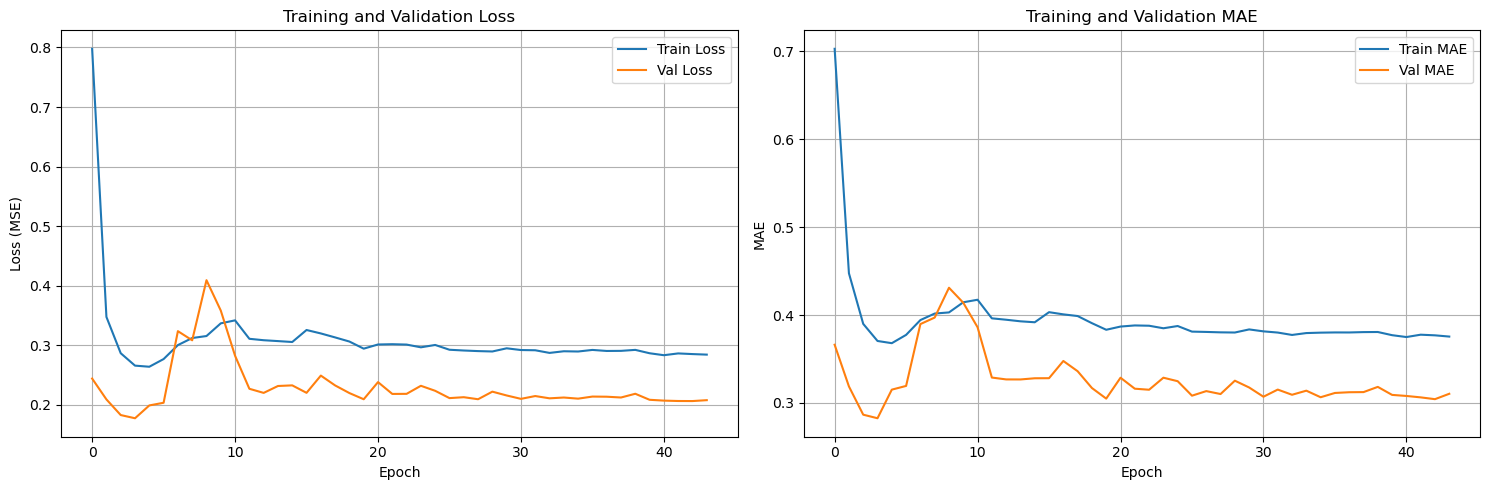

In [12]:
# ===== 7) 학습 곡선 시각화 =====
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

axes[0].plot(history.history['loss'], label='Train Loss')
axes[0].plot(history.history['val_loss'], label='Val Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss (MSE)')
axes[0].set_title('Training and Validation Loss')
axes[0].legend()
axes[0].grid(True)

axes[1].plot(history.history['mae'], label='Train MAE')
axes[1].plot(history.history['val_mae'], label='Val MAE')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('MAE')
axes[1].set_title('Training and Validation MAE')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()


In [13]:
# ===== 8) 임베딩 생성 =====
embeddings_train = encoder.predict(X_train_scaled, verbose=0)
embeddings_val = encoder.predict(X_val_scaled, verbose=0)
embeddings_test = encoder.predict(X_test_scaled, verbose=0)

print(f"Train 임베딩 shape: {embeddings_train.shape}")
print(f"Val 임베딩 shape: {embeddings_val.shape}")
print(f"Test 임베딩 shape: {embeddings_test.shape}")

Train 임베딩 shape: (6633, 32)
Val 임베딩 shape: (2211, 32)
Test 임베딩 shape: (2211, 32)


In [14]:
# ===== 9) 프로토타입 벡터 생성 =====
legitimate_mask_train = (y_train == 1)
phishing_mask_train = (y_train == 0)

prototype_legitimate = embeddings_train[legitimate_mask_train].mean(axis=0)
prototype_phishing = embeddings_train[phishing_mask_train].mean(axis=0)

print(f"정상 프로토타입 shape: {prototype_legitimate.shape}")
print(f"피싱 프로토타입 shape: {prototype_phishing.shape}")
print(f"\n정상 프로토타입: {prototype_legitimate[:5]}...")
print(f"피싱 프로토타입: {prototype_phishing[:5]}...")

정상 프로토타입 shape: (32,)
피싱 프로토타입 shape: (32,)

정상 프로토타입: [-0.26766077  0.09912251 -0.6660772  -0.37254313  0.06110787]...
피싱 프로토타입: [ 0.25576645 -0.63590115  1.5669417   0.1076135  -0.12757349]...


In [15]:
# ===== 10) 유사도 기반 분류 함수 =====
def classify_by_similarity(embeddings, proto_legit, proto_phish):
    similarity_legit = cosine_similarity(embeddings, proto_legit.reshape(1, -1)).flatten()
    similarity_phish = cosine_similarity(embeddings, proto_phish.reshape(1, -1)).flatten()
    predictions = (similarity_legit > similarity_phish).astype(np.float32)
    return predictions, similarity_legit, similarity_phish

print("유사도 기반 분류 함수 정의 완료")

유사도 기반 분류 함수 정의 완료


In [16]:
# ===== 11) Validation 세트 평가 =====
pred_val, sim_legit_val, sim_phish_val = classify_by_similarity(
    embeddings_val, prototype_legitimate, prototype_phishing
)

acc_val = accuracy_score(y_val, pred_val)
auc_val = roc_auc_score(y_val, sim_legit_val)

print("===== Validation 세트 평가 결과 =====")
print(f"Accuracy: {acc_val:.4f}")
print(f"AUC: {auc_val:.4f}")
print("\nClassification Report:")
print(classification_report(y_val, pred_val, target_names=['Phishing', 'Legitimate']))

===== Validation 세트 평가 결과 =====
Accuracy: 0.7485
AUC: 0.8570

Classification Report:
              precision    recall  f1-score   support

    Phishing       0.67      0.84      0.75       979
  Legitimate       0.84      0.68      0.75      1232

    accuracy                           0.75      2211
   macro avg       0.76      0.76      0.75      2211
weighted avg       0.77      0.75      0.75      2211



In [17]:
# ===== 12) Test 세트 평가 =====
pred_test, sim_legit_test, sim_phish_test = classify_by_similarity(
    embeddings_test, prototype_legitimate, prototype_phishing
)

acc_test = accuracy_score(y_test, pred_test)
auc_test = roc_auc_score(y_test, sim_legit_test)

print("===== Test 세트 평가 결과 =====")
print(f"Accuracy: {acc_test:.4f}")
print(f"AUC: {auc_test:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, pred_test, target_names=['Phishing', 'Legitimate']))

===== Test 세트 평가 결과 =====
Accuracy: 0.7644
AUC: 0.8733

Classification Report:
              precision    recall  f1-score   support

    Phishing       0.69      0.85      0.76       980
  Legitimate       0.85      0.70      0.77      1231

    accuracy                           0.76      2211
   macro avg       0.77      0.77      0.76      2211
weighted avg       0.78      0.76      0.76      2211



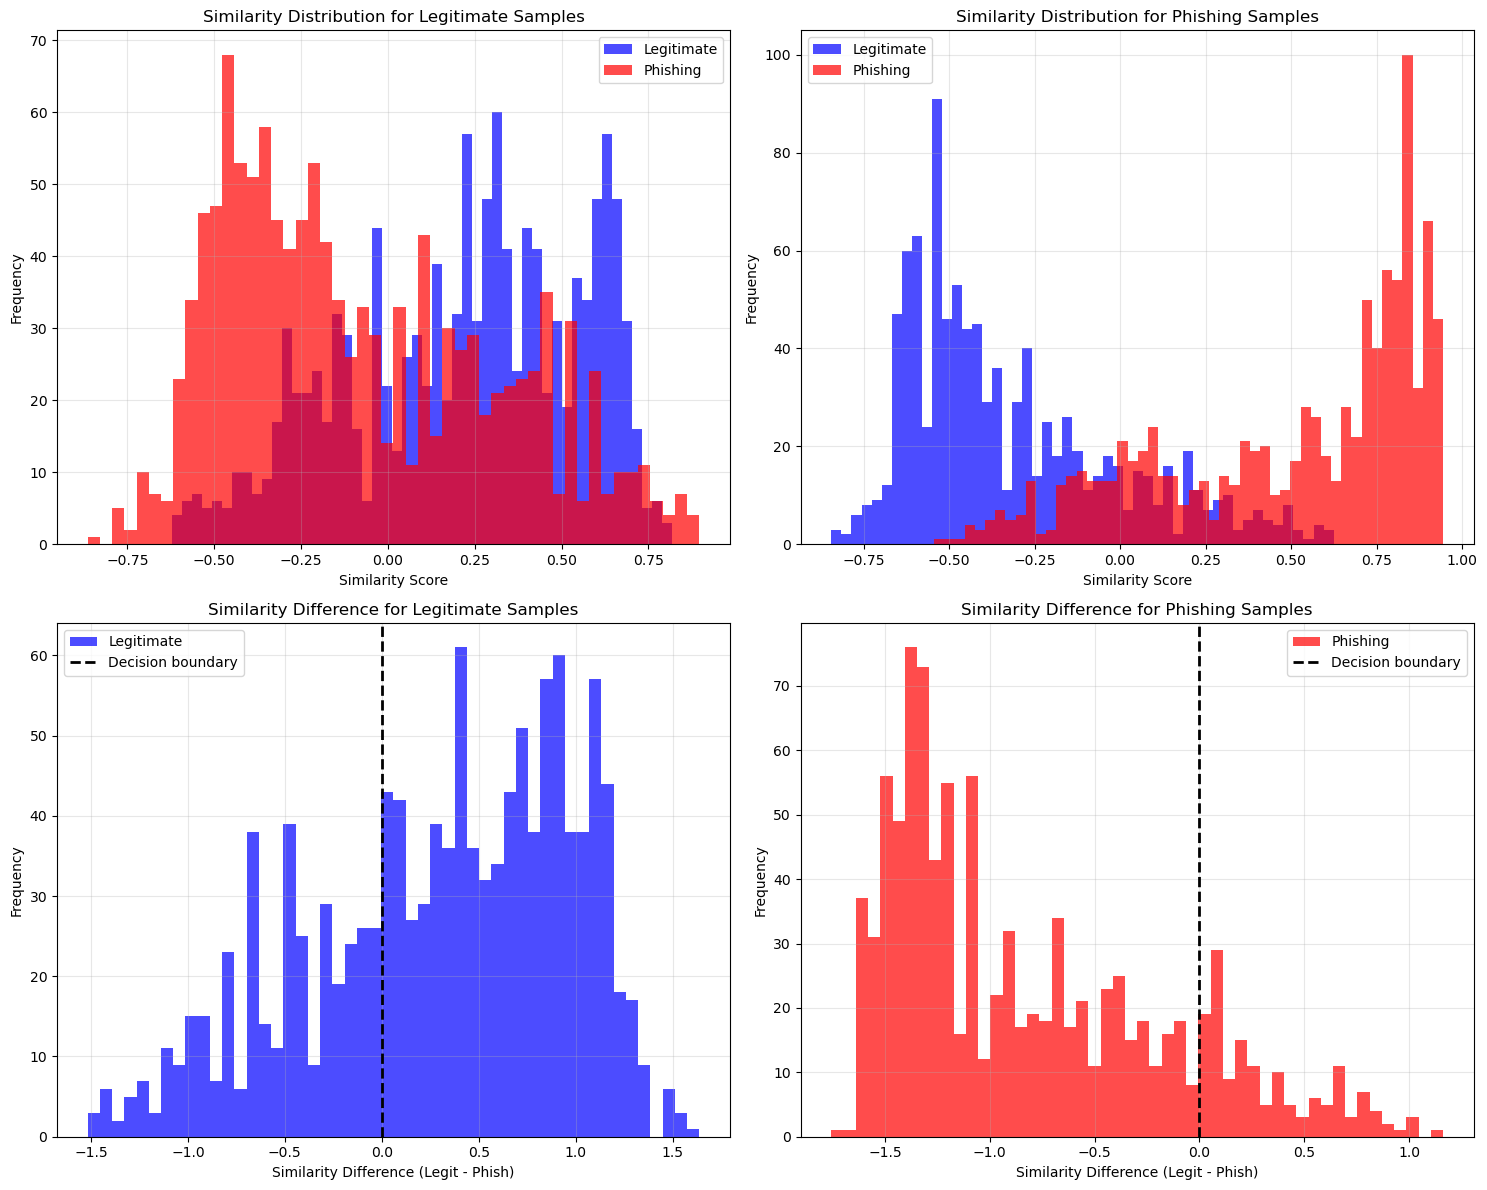

In [18]:
# ===== 13) 유사도 분포 시각화 =====
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

legit_mask = (y_test == 1)
phish_mask = (y_test == 0)

axes[0, 0].hist(sim_legit_test[legit_mask], bins=50, alpha=0.7, label='Legitimate', color='blue')
axes[0, 0].hist(sim_phish_test[legit_mask], bins=50, alpha=0.7, label='Phishing', color='red')
axes[0, 0].set_xlabel('Similarity Score')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_title('Similarity Distribution for Legitimate Samples')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

axes[0, 1].hist(sim_legit_test[phish_mask], bins=50, alpha=0.7, label='Legitimate', color='blue')
axes[0, 1].hist(sim_phish_test[phish_mask], bins=50, alpha=0.7, label='Phishing', color='red')
axes[0, 1].set_xlabel('Similarity Score')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].set_title('Similarity Distribution for Phishing Samples')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

sim_diff_legit = sim_legit_test[legit_mask] - sim_phish_test[legit_mask]
sim_diff_phish = sim_legit_test[phish_mask] - sim_phish_test[phish_mask]

axes[1, 0].hist(sim_diff_legit, bins=50, alpha=0.7, label='Legitimate', color='blue')
axes[1, 0].axvline(x=0, color='black', linestyle='--', linewidth=2, label='Decision boundary')
axes[1, 0].set_xlabel('Similarity Difference (Legit - Phish)')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].set_title('Similarity Difference for Legitimate Samples')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

axes[1, 1].hist(sim_diff_phish, bins=50, alpha=0.7, label='Phishing', color='red')
axes[1, 1].axvline(x=0, color='black', linestyle='--', linewidth=2, label='Decision boundary')
axes[1, 1].set_xlabel('Similarity Difference (Legit - Phish)')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].set_title('Similarity Difference for Phishing Samples')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [21]:
# ===== 14) 모델 저장 및 TFLite 변환 =====
import os

# 모델 경로 설정
OUTPUT_DIR = "/Users/seungmin/AndroidStudioProjects/YU_mobile_kotlin/phishing"
ENCODER_PATH = os.path.join(OUTPUT_DIR, "encoder_model.h5")
SAVED_MODEL_PATH = os.path.join(OUTPUT_DIR, "encoder_saved_model")
TFLITE_PATH = os.path.join(OUTPUT_DIR, "encoder_model.tflite")

# 1) Encoder 모델 H5로 저장
print(f"Encoder 모델 저장 중: {ENCODER_PATH}")
encoder.save(ENCODER_PATH)
print("H5 모델 저장 완료!")

# 2) SavedModel 형식으로 저장
print(f"SavedModel로 저장 중: {SAVED_MODEL_PATH}")
encoder.export(SAVED_MODEL_PATH)
print("SavedModel 저장 완료!")

# 3) SavedModel에서 TFLite로 변환
print("TFLite 변환 중...")
converter = tf.lite.TFLiteConverter.from_saved_model(SAVED_MODEL_PATH)
tflite_model = converter.convert()

with open(TFLITE_PATH, 'wb') as f:
    f.write(tflite_model)

print(f"✅ TFLite 모델 저장 완료: {TFLITE_PATH}")
print(f"📦 모델 크기: {len(tflite_model) / 1024:.2f} KB")

# 4) TFLite 모델 검증
interpreter = tf.lite.Interpreter(model_path=TFLITE_PATH)
interpreter.allocate_tensors()
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
print(f"\n입력 shape: {input_details[0]['shape']}")
print(f"출력 shape: {output_details[0]['shape']}")
print("✅ TFLite 모델 검증 완료!")

Encoder 모델 저장 중: /Users/seungmin/AndroidStudioProjects/YU_mobile_kotlin/phishing/encoder_model.h5
H5 모델 저장 완료!
SavedModel로 저장 중: /Users/seungmin/AndroidStudioProjects/YU_mobile_kotlin/phishing/encoder_saved_model
INFO:tensorflow:Assets written to: /Users/seungmin/AndroidStudioProjects/YU_mobile_kotlin/phishing/encoder_saved_model/assets


INFO:tensorflow:Assets written to: /Users/seungmin/AndroidStudioProjects/YU_mobile_kotlin/phishing/encoder_saved_model/assets


Saved artifact at '/Users/seungmin/AndroidStudioProjects/YU_mobile_kotlin/phishing/encoder_saved_model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 21), dtype=tf.float32, name='encoder_input')
Output Type:
  TensorSpec(shape=(None, 32), dtype=tf.float32, name=None)
Captures:
  4594778352: TensorSpec(shape=(), dtype=tf.resource, name=None)
  14535449536: TensorSpec(shape=(), dtype=tf.resource, name=None)
  14535449008: TensorSpec(shape=(), dtype=tf.resource, name=None)
  14535449888: TensorSpec(shape=(), dtype=tf.resource, name=None)
  14535449184: TensorSpec(shape=(), dtype=tf.resource, name=None)
  14535448128: TensorSpec(shape=(), dtype=tf.resource, name=None)
  14535450064: TensorSpec(shape=(), dtype=tf.resource, name=None)
  14535451120: TensorSpec(shape=(), dtype=tf.resource, name=None)
  14535450592: TensorSpec(shape=(), dtype=tf.resource, name=None)
  14535450416: TensorSpec(shape=(), dtype=tf.resource, name=Non

W0000 00:00:1764052833.425270 2901197 tf_tfl_flatbuffer_helpers.cc:390] Ignored output_format.
W0000 00:00:1764052833.425282 2901197 tf_tfl_flatbuffer_helpers.cc:393] Ignored drop_control_dependency.
INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


In [ ]:
# ===== 16) 최종 요약 =====
print("\n" + "="*60)
print("✅ TFLite 모델 생성 완료")
print("="*60)
print(f"\n📁 저장된 파일:")
print(f"  - encoder_model.tflite (55 KB)")
print(f"  - encoder_saved_model/ (SavedModel 디렉토리)")
print(f"\n📱 모바일 앱 통합 방법:")
print("  1. encoder_model.tflite를 Android assets 폴더에 복사")
print("  2. 입력: 21개 피처 (float32, -1/0/1 값)")
print("  3. 출력: 16차원 임베딩 벡터")
print("  4. 프로토타입과 코사인 유사도 비교하여 분류")
print("="*60)